The aim of this project is to detect whether a website is spam based on its URL

# All imports

In [149]:

#######data management/analysis libraries, and storing models:
import pandas as pd
import os
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sqlite3 #for sql tables
from pickle import dump, load #for storing models after tunning
import json #to work with json data format


#######data prcessing, rescaling or transformation
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk #pip install nltk , library to clean text
from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import regex as re

#######Iterative imputer to fill missing numerical data:
    # explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
    # now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#######feature selection selectkbest and method
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression, f_classif

#######splitting train and test and model tunning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV

#######model performance assessment
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report, ConfusionMatrixDisplay, confusion_matrix

#######Supervised/unsupervised ML models
from sklearn.cluster import KMeans #unsupervised
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV #supervised
from sklearn.neighbors import NearestNeighbors #unsipervised
from xgboost import XGBClassifier #boosting
from sklearn.tree import DecisionTreeClassifier #tree model
from sklearn import tree #tree plot
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.naive_bayes import MultinomialNB,  GaussianNB, BernoulliNB #bayes models
from sklearn.svm import SVC #nlp

#######Deep learning libraries:
# from tensorflow.keras.preprocessing import image #pip install tensorflow
# from tensorflow.keras.utils import image_dataset_from_directory
# from tensorflow.keras.losses import categorical_crossentropy
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# Data cleaning/processing section

## Loading data

In [150]:
url='https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'

spam_raw=pd.read_csv(url)

## Preliminary data exploration

In [151]:
spam_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [152]:
spam_raw.head(10)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
5,https://www.brookings.edu/interactives/reopeni...,False
6,https://www.reuters.com/investigates/special-r...,False
7,https://www.theatlantic.com/magazine/archive/2...,False
8,https://www.vox.com/2020/6/17/21294680/john-bo...,False
9,https://www.theguardian.com/travel/2020/jun/18...,False


Counting is_spam categories: variable is umbalanced

In [153]:
spam_raw.is_spam.value_counts()

False    2303
True      696
Name: is_spam, dtype: int64

Checking for duplicates: there are 630 duplicates

In [154]:
spam_raw.duplicated().sum()

630

In [155]:
spam_raw.drop_duplicates(inplace=True)
spam_raw.reset_index(inplace=True, drop=True)

Re-checking the class count for dependent variable: still umbalanced

In [156]:
spam_raw.is_spam.value_counts()

False    2125
True      244
Name: is_spam, dtype: int64

## URL transformation

First fuction segments the URLs into parts according to their punctuation marks

Second function removes stopwords and lemmatize

In [157]:
def url_transform(link):

  link=link.lower() #converting to lowercase

  #segmenting url by punctuation marks: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~

  link=re.sub(f'[{re.escape(string.punctuation)}]', ' ', link) #removes punctuation and adds a space
  linl=re.sub(r'\s+', " ", link) #removes white spaces
  link=link.split() #splits link content
  return link

#download('punkt') this one is not needed I already have a list of individual words

download("wordnet")
lemmatizer=WordNetLemmatizer()

download('stopwords')
stopwords=stopwords.words('english')

def nltk_funct(link, lemmatizer=lemmatizer):
#simplify words with lemmatizer
  link=[lemmatizer.lemmatize(token) for token in link]
#removing stopwords
  link=[token for token in link if token not in stopwords]

  return link


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Applying URL transformatio to dataframe

In [158]:
spam_raw['url']=spam_raw['url'].apply(url_transform, nltk_funct)
spam_raw.head(10)

,url,is_spam
0,"[https, briefingday, us8, list, manage, com, u...",True
1,"[https, www, hvper, com]",True
2,"[https, briefingday, com, m, v4n3i4f3]",True
3,"[https, briefingday, com, n, 20200618, m, comm...",False
4,"[https, briefingday, com, fan]",True
5,"[https, www, brookings, edu, interactives, reo...",False
6,"[https, www, reuters, com, investigates, speci...",False
7,"[https, www, theatlantic, com, magazine, archi...",False
8,"[https, www, vox, com, 2020, 6, 17, 21294680, ...",False
9,"[https, www, theguardian, com, travel, 2020, j...",False


## Inspecting common words

https is one of the most common words, which is expected as all urls start with this term

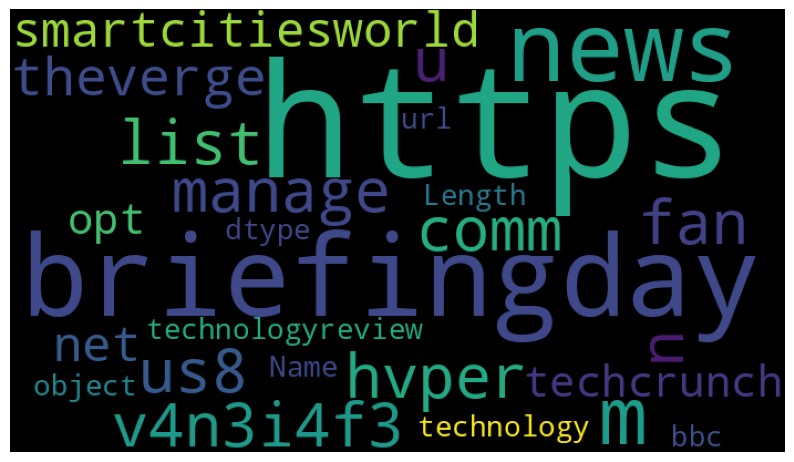

In [159]:
common_url_words= WordCloud(width=700, height=400, background_color='black', max_words=1000, min_font_size=15, random_state=42)
common_url_words.generate(str(spam_raw['url']))

fig=plt.figure(figsize=(10,10))
plt.imshow(common_url_words)
plt.axis('off')
plt.show()

## Splitting data into train and test

In [160]:
X=spam_raw['url']
y=spam_raw['is_spam']

#using option stratify to ~balance y
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,random_state=42, stratify=y, test_size=0.2)

## Vectorising URLs

In [161]:
'''transforms URLS into tfid vectorizer format by
converting each URL it into a text chain separated with spaces
'''
X_train=[' '.join(word) for word in X_train]
X_test=[' '.join(word) for word in X_test]

vector=TfidfVectorizer()
X_train=vector.fit_transform(X_train)
X_test=vector.transform(X_test)


# NLP model: SVM-SVC - support vector machine - support vector classification

## Training baseline model

In [162]:
model = SVC(random_state = 42)
model.fit(X_train, y_train)

SVC(random_state=42)

### Baseline performance

The baseline SVC model accuracy is 91%. The model has a good baseline accuracy considering that default hyperparameters were used. The accuracy differs with train accuracy by roughly 7 percentage points, showing some mild signals of overfitting

In [163]:
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

base_acc=accuracy_score(y_pred, y_test)

print('Train accuracy: ', accuracy_score(y_pred_train, y_train))
print('Baseline test accuracy: ', base_acc)

Train accuracy:  0.9820580474934036
Baseline test accuracy:  0.9135021097046413


Storing confusion matrix to compare it with tunned model:

In [164]:
base_cm=ConfusionMatrixDisplay(confusion_matrix =confusion_matrix(y_test, y_pred), display_labels = ['NO Spam URL', 'Spam URL'])

## Hyperparameter optimisation

In [165]:
hyprms={
    'C': list(np.linspace(10,100,10)),
    'degree': list(np.arange(2,31,4)),
    'decision_function_shape': ['ovo', 'ovr'],
    'gamma': ['scale', 'auto']
}

In [166]:
hyprms

{'C': [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0],
 'degree': [2, 6, 10, 14, 18, 22, 26, 30],
 'decision_function_shape': ['ovo', 'ovr'],
 'gamma': ['scale', 'auto']}

In [167]:
model_opt=RandomizedSearchCV(model, hyprms, n_iter=100,scoring='accuracy', cv=10, refit=True, random_state=42)

Training model

In [168]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

model_opt.fit(X_train, y_train)
result=pd.DataFrame(model_opt.cv_results_)

### Optimised model performance:

Obtaining best hyperparameters:

In [169]:
best_params=model_opt.best_params_

In [170]:
opt_model=SVC(random_state=42, **best_params)
opt_model.fit(X_train, y_train)

SVC(C=80.0, decision_function_shape='ovo', degree=14, random_state=42)

Storing model:

In [171]:
dump(opt_model, open('svc_c10_ovo_degr2_seed42.pk', 'wb'))
#dump(boost_opt, open('/workspaces/Boosting_ML_Diabetes/boostgblinear_depth87_wgt0.6_estim145_seed42.pk', 'wb'))

There are some signs of overfitting remaining:

In [172]:
y_pred_train_opt = opt_model.predict(X_train)
y_pred_opt = opt_model.predict(X_test)

opt_acc=accuracy_score(y_pred_opt, y_test)

print('Train accuracy: ', accuracy_score(y_pred_train_opt, y_train))
print('Baseline test accuracy: ', opt_acc)

Train accuracy:  1.0
Baseline test accuracy:  0.9156118143459916


Baseline vs optimised acuracy does not change much after optimising

In [173]:
print('Baseline accuracy: ', base_acc)
print('Optimised accuracy: ', opt_acc)

Baseline accuracy:  0.9135021097046413
Optimised accuracy:  0.9156118143459916


Comparing confusion matrix:

The optimised model showed some improvement, compared to the baseline model, in detecting true spam websites since a higher number of real spam websites are now predicted as spam.

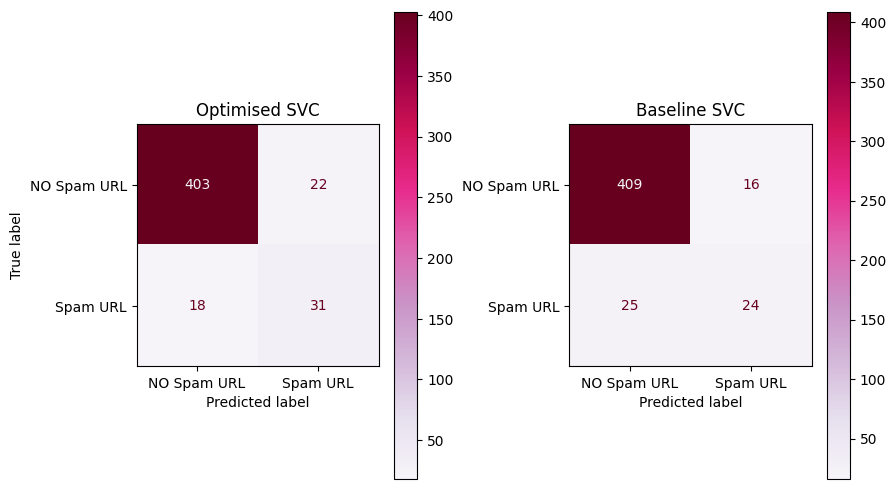

In [174]:
opt_cf =ConfusionMatrixDisplay(
    confusion_matrix =confusion_matrix(y_test, y_pred_opt), display_labels = ['NO Spam URL', 'Spam URL'])
# plot CM
fig, ax= plt.subplots(1,2, figsize=(9,5))
opt_cf.plot(cmap = 'PuRd', ax=ax[0])
ax[0].set_title('Optimised SVC')

base_cm.plot(cmap = 'PuRd', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Baseline SVC')

plt.tight_layout()
plt.show()